# BACQUET Maxime et CARON Mathieu

# TP2 : Estimation de densité par noyaux

## Introduction à l'estimation statistique - G3 SDIA

Dans le cadre de cours, nous avons étudié jusqu'à présent des méthodes d'estimation dites paramétriques : on se fixe une famille de lois paramétrique à laquelle la loi ayant généré les données est censée appartenir, puis on cherche à estimer les paramètres à partir des données (par exemple par maximum de vraisemblance).

Dans ce TP, nous introduisons une méthode d'estimation **non-paramétrique** de la fonction de densité appelée estimation par noyaux (*kernel estimation* en anglais). C'est-à-dire que nous ne faisons plus d'hypothèse sur la loi ayant généré les données, et nous cherchons plutôt à estimer directement la densité de la loi parente $f$ (que l'on supposera continue). Ainsi cette méthode ne concerne que les variables aléatoires continues.

### Instructions

1. Renommer votre notebook sous la forme `tp1_Nom1_Nom2.ipynb`, et inclure le nom du binôme dans le notebook. 

2. Votre code, ainsi que toute sortie du code, doivent être commentés !

3. Déposer votre notebook sur Moodle dans la section prévue à cet effet avant la date limite : 22 Octobre 2023, 23h59.

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import scipy.stats as ss

### Partie 1 - Histogrammes

On considère $(x_1, ..., x_n)$ $n$ réalisations indépendantes d'une variable aléatoire réelle.

Soit $x_0 \in \mathbb{R}$ et $h > 0$. On partitionne la droite réelle en intervalles de même longueur $h$, aussi appelés *bins* :
$$\forall k \in \mathbb{Z},~B_k =~]x_0 + (k-1)h~;~x_0 + kh].$$

L'histogramme est une fonction constante par morceaux définie de la manière suivante :
$$\forall x \in B_k,~H_n(x) = n_k,$$
où $n_k$ est le nombre de réalisations appartenant à l'intervalle $B_k$.

**Q1**. Comment normaliser $H_n$ pour obtenir un estimateur de la fonction de densité ? On rappelera que $\int_{\mathbb{R}} f(x) dx = 1$.

Dans la suite, on note $\hat{f}_n$ cet estimateur de $f$.

Pour tout $x \in \mathbb{R}$, calculer le biais et la variance de $\hat{f}_n(x)$. Commenter.

In [2]:
# Fonction pour calculer l'estimateur de la densité
def f_hat(x, H_n, n, h):
    return H_n(x) / (n * h)

**Q2**. On fixe $x_0 = \min_i x_i$. La valeur de $h$ peut être fixée indirectement en fixant à la place le nombre de *bins* $N_b$ entre $\min_i x_i$ et $\max_i x_i$, on a alors
$$h = \frac{\max_i x_i - \min_i x_i}{N_b}.$$

Générer 200 points d'un modèle de mélange gaussien à 2 composantes avec $\mu_1 = -2.5, \mu_2 = 1.5, \sigma_1 = \sigma_2 = 1, \pi_1 = 0.4, \pi_2 = 0.6$.

Montrer l'influence de la valeur de $h$ sur l'histogramme (normalisé). On utilisera la fonction $\texttt{np.histogram}$ pour calculer automatiquement les $n_k$, et la fonction $\texttt{plt.bar}$ pour représenter $\hat{f}_n$. Superposer la densité théorique du modèle de mélange gaussien.

On pourra afficher plusieurs histogrammes obtenus avec différentes valeurs de $N_b$ à l'aide de $\texttt{plt.subplots}$. Commenter.

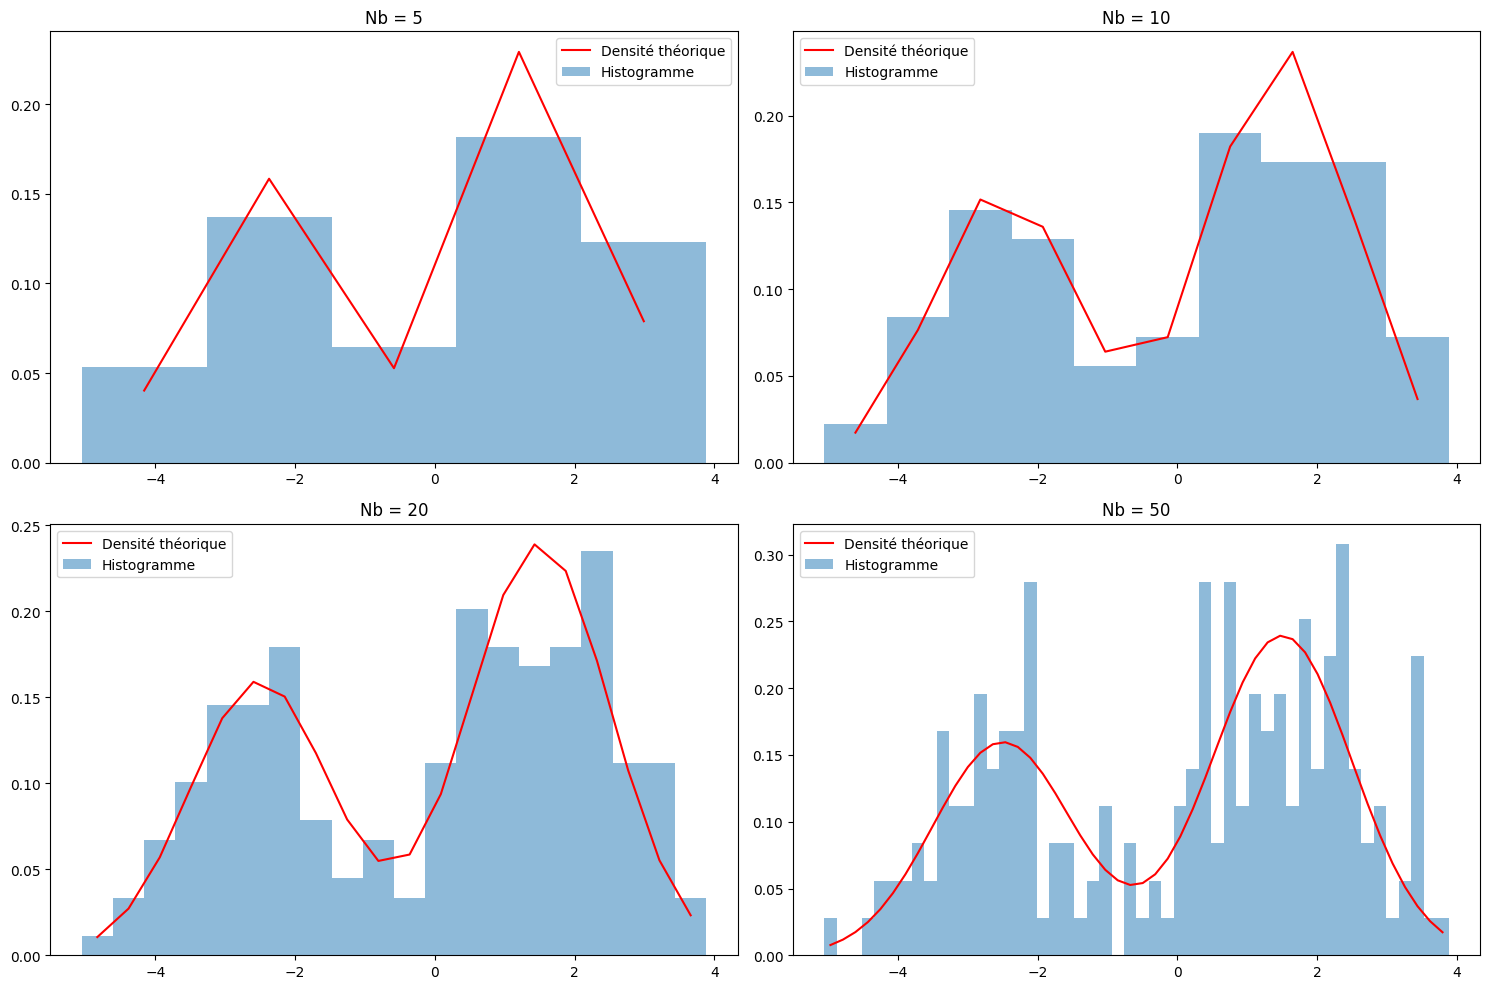

In [8]:
import numpy as np
from scipy.stats import norm

# Generate data from GMM

# Paramètres du modèle de mélange gaussien
mu_1, mu_2 = -2.5, 1.5
sigma_1, sigma_2 = 1, 1
pi_1, pi_2 = 0.4, 0.6
N = 200

# On génére les données
np.random.seed(0)
samples_1 = np.random.normal(mu_1, sigma_1, int(N * pi_1))
samples_2 = np.random.normal(mu_2, sigma_2, int(N * pi_2))
samples = np.concatenate((samples_1, samples_2))

# Fixer x0 et calculer h en fonction de Nb
x_0 = np.min(samples)
max_x = np.max(samples)
min_x = np.min(samples)

# On va tester différentes valeurs de Nb
N_b_values = [5, 10, 20, 50]

# Plot histograms with varying number of bins
plt.figure(figsize=(15, 10))

for i, N_b in enumerate(N_b_values):
    h = (max_x - min_x) / N_b
    hist, bins = np.histogram(samples, bins=N_b, range=(min_x, max_x), density=True)

    x_vals = (bins[:-1] + bins[1:]) / 2 # Milieu de chaque intervalle

    # On calcule ensuite la densité théorique du modèle de mélange gaussien
    pdf = (pi_1 * norm.pdf(x_vals, mu_1, sigma_1) + pi_2 * norm.pdf(x_vals, mu_2, sigma_2))

    plt.subplot(2, 2, i+1)
    plt.bar(x_vals, hist, width=h, alpha=0.5, label='Histogramme')
    plt.plot(x_vals, pdf, color='red', label='Densité théorique')
    plt.title(f'Nb = {N_b}')
    plt.legend()

plt.savefig(f'img\histograms.png')  # On enregistre les figures dans notre dossier img
plt.tight_layout()
plt.show()

On s'aperçoit que plus notre valeur de Nb augmente, plus nos densités théoriques sont lisses. Attention à trouver un équilibre et ne pas avoir un sur-ajustement ou sous-ajustement des données ce pourquoi on peut tracer pour différentes valeurs de Nb.

**Q3**. Quelles sont les principales limitations de l'utilisation de l'histogramme comme estimateur de la fonction de densité ?

Des limitations de l'utilisation de l'histogramme peuvent être :

- la sensibilité au choix de la largeur de l'intervalle (bin size) car le choix de la taille de l'intervalle influence l'apparence de l'histogramme et donc l'estimation de la densité.

- De plus, il n'y a pas de continuité de la fonction estimée. En effet, l'histogramme est une fonction constante par morceaux, ce qui signifie qu'il ne fournit pas une estimation lisse de la densité.

- Faible performance avec des échantillon de petites tailles.

- Enfin, comme vu précedemment le choix du nombre de bins peut provoquer un sur-ajustement ou sous ajustement.

### Partie 2 - Estimation par noyaux (en 1D)

$(x_1, ..., x_n)$ sont toujours $n$ réalisations indépendantes d'une variable aléatoire réelle.

L'une des motivations principales est de faire directement dépendre l'estimation des données, et de ne plus dépendre de découpages arbitraires de $\mathbb{R}$. Pour cela, on propose la méthodologie suivante :
- Choisir une fonction $K$ appelée "noyau". On choisit $K$ positive ou nulle, symétrique, et d'intégrale 1.
- Centrer $K$ sur chaque observation $x_i$.
- L'estimateur à noyaux est alors
$$\hat{f}_n(x) = \frac{1}{n} \sum_{i=1}^n K(x - x_i).$$

On pourra par exemple choisir des noyaux $K$ continus, dérivables partout... Propriétés dont $\hat{f}_n$ héritera.

**Q1**. On utilise dans un premier temps un noyau gaussien :
$$K(x) = \frac{1}{\sqrt{2 \pi}} \exp(-\frac{x^2}{2}).$$

Prendre 10 observations des données générées dans la partie 1. Sur un même graphique, représenter les 10 noyaux (normalisés par $n$) centrés sur les observations, et l'estimateur à noyaux $\hat{f}_n$. Superposer la vraie densité $f$. Commenter.

In [10]:
# On créé une fonction pour calculer le noyau gaussien K(x)
def gaussian_kernel(x):
    return (1 / np.sqrt(2 * np.pi)) * np.exp(-x**2 / 2)

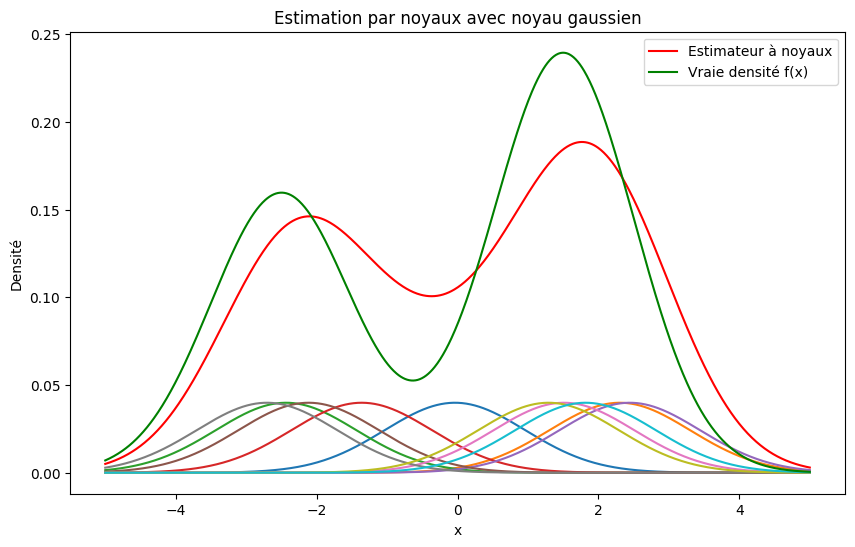

In [29]:
# Randomly select 10 points from previously generated dataset

observations = np.random.choice(samples, size=10, replace=False)

# Implement the kernel density estimator and plot it

# On calcule les 10 noyaux centrés sur les observations

# Valeurs de x pour l'affichage
x_vals = np.linspace(-5, 5, 1000)
n = len(observations)
kernels = [gaussian_kernel(x_vals - obs) / n for obs in observations]

# On calcule l'estimateur à noyaux en faisant la somme
kernel_estimate = np.sum(kernels, axis=0)

# On calcule la vraie densité f(x)
mu_1, mu_2 = -2.5, 1.5
sigma_1, sigma_2 = 1, 1
pi_1, pi_2 = 0.4, 0.6
pdf = (pi_1 * norm.pdf(x_vals, mu_1, sigma_1) + pi_2 * norm.pdf(x_vals, mu_2, sigma_2))

# Affichage
plt.figure(figsize=(10, 6))
for kernel in kernels:
    plt.plot(x_vals, kernel)

plt.plot(x_vals, kernel_estimate, color='red', label='Estimateur à noyaux')
plt.plot(x_vals, pdf, color='green', label='Vraie densité f(x)')
plt.xlabel('x')
plt.ylabel('Densité')
plt.legend()
plt.title('Estimation par noyaux avec noyau gaussien')
plt.savefig(f'img\estimation-par-noyaux-avec-noyau-gaussien.png')  # On enregistre les figures dans notre dossier img
plt.show()

En observant le graphique, on peut voir que l'estimateur à noyaux (rouge) se rapproche de la vraie denité f(x) en vert. Cependant le fait de choisir 10 valeurs aléatoires nous montrent parfois que cette courbe rouge est plus éloignée de la courbe verte. 

De plus, nous avons remarqué que l'estimation des noyaux tend à sous-estimer les pics de la densité.

**Q2**. En réalité, on souhaite faire dépendre cet estimateur d'un paramètre de lissage $h > 0$, qu'on appelle largeur de fenêtre (ou *bandwidth* en anglais).

Le (véritable) estimateur à noyaux, aussi appelé méthode de Parzen-Rosenblatt (du nom des deux statisticiens l'ayant développée) est :
$$\hat{f}_n(x) = \frac{1}{nh} \sum_{i=1}^n K(\frac{x - x_i}{h}).$$

Vérifier que c'est bien l'estimateur d'une densité.

Implémenter cet estimateur sur les données de la partie 1, et montrer l'influence de la valeur de $h$. On pourra encore utiliser $\texttt{plt.subplots}$. Commenter.

In [30]:
# Vérifier que c'est bien l'estimateur d'une densité. (Latex)

In [31]:
# On créé une fonction pour l'estimateur de Parzen-Rosenblatt
def parzen_rosenblatt(x, observations, h):
    n = len(observations)
    return (1 / (n * h)) * np.sum(gaussian_kernel((x - observations) / h))

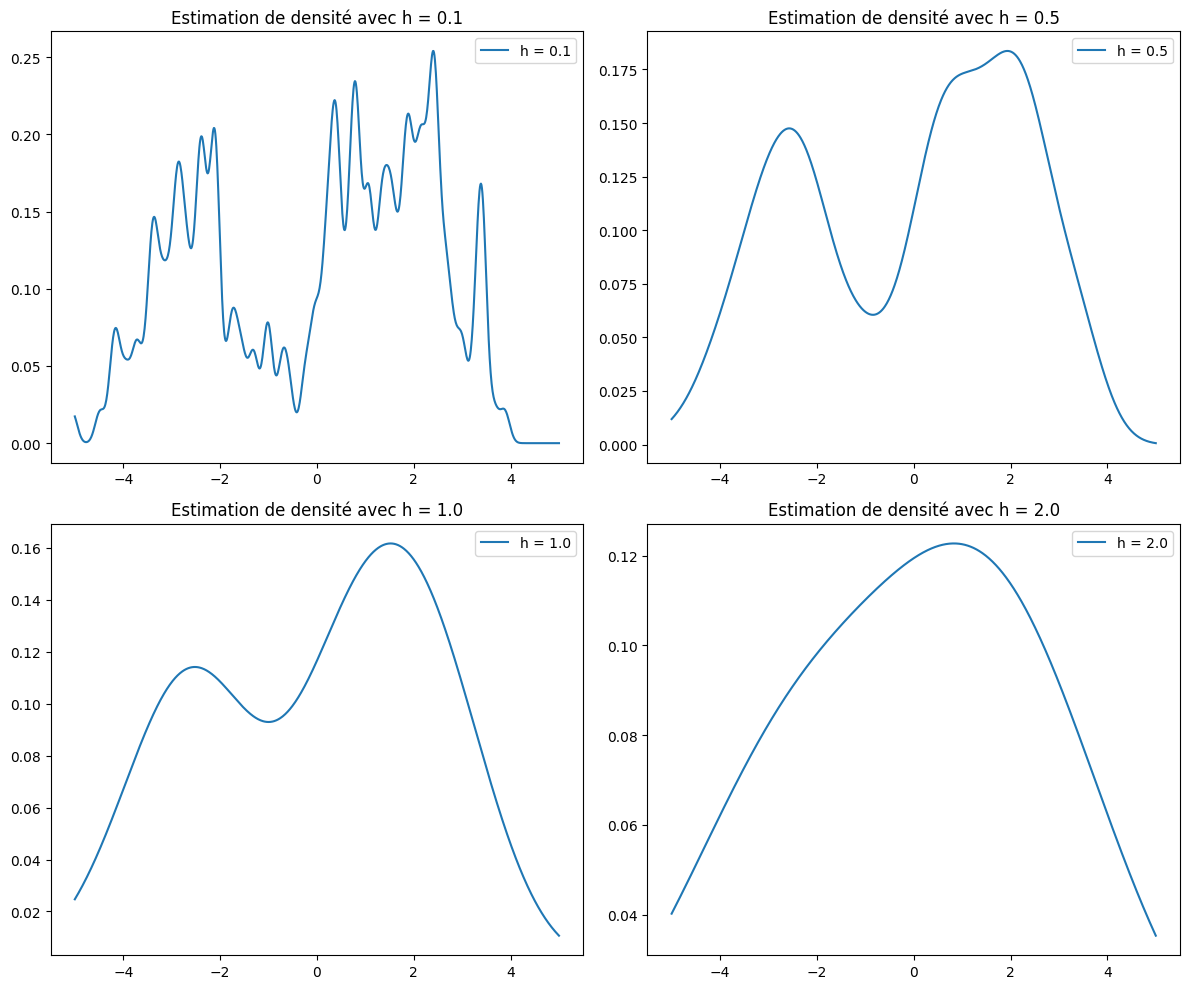

In [32]:
# Implement the (true) kernel estimator and show the influence of h

# On génére différentes valeurs de h
h_values = [0.1, 0.5, 1.0, 2.0]

# On créé une grille de points x pour l'estimation
x_vals = np.linspace(-5, 5, 1000)

# On affiche les résultats pour différentes valeurs de h
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for i, h in enumerate(h_values):
    # On calcule l'estimation de densité pour chaque valeur de h
    density_estimate = np.array([parzen_rosenblatt(x, samples, h) for x in x_vals])

    # On trace l'estimation de densité
    axes[i].plot(x_vals, density_estimate, label=f'h = {h}')
    axes[i].set_title(f'Estimation de densité avec h = {h}')
    axes[i].legend()

plt.tight_layout()
plt.show()


----- Votre réponse ici -----

**Q3.** Nous allons maintenant regarder d'autres noyaux. Cette fois-ci, nous n'implémenterons pas l'estimateur à la main mais ferons appel à la librairie `scikit-learn` qui implémente six noyaux différents (dont le noyau gaussien). La méthode est implémentée dans `sklearn.neighbors.KernelDensity`.

Représenter les six noyaux. Commenter.

À longueur de fenêtre fixée (par exemple $h = 0.5$), montrer l'influence des différentes fenêtres. On pourra encore utiliser $\texttt{plt.subplots}$. Commenter.

In [ ]:
from sklearn.neighbors import KernelDensity

In [ ]:
# Represent the 6 different kernels implemented in scikit-learn

# # # # # # # # #
# YOUR CODE HERE #
# # # # # # # # #


# Show the influence of the kernel (with fixed bandwidth)

# # # # # # # # #
# YOUR CODE HERE #
# # # # # # # # #

----- Votre réponse ici -----

**Q4 (bonus)**. La question du choix de $h$ a été largement étudiée dans la littérature. Par exemple, la librairie `scikit-learn` embarque pour l'argument *bandwidth* deux règles de calcul empiriques appelées règle de Scott et règle de Silvermann, qui fixent la valeur de $h$ en fonction de $n$ et $d$ (la dimension des données).

À l'aide d'une notion du cours, pouvez-vous imaginer un critère d'optimalité permettant de fixer la valeur de $h$ ?

---- Votre réponse ici -----

### Partie 3 : Estimation par noyaux (en 2D)

L'estimation de densité par noyaux peut être étendue en $d$ dimensions. On peut alors définir $\mathbf{H}$ une matrice symmétrique de taille $d \times d$ définie positive pour les longueurs de fenêtres (NB : `scikit-learn` ne le permet pas et n'a qu'un paramètre scalaire en $d$ dimensions).

**Q1**. Reprendre le dataset *Old Faithful* étudié au TP1, et faire une estimation par noyaux de la densité en utilisant `scikit-learn`. Le choix du noyau et de la longueur de fenêtre est laissé libre.

Afficher la densité obtenue. On pourra par exemple la représenter sous forme de *heatmap* avec $\texttt{plt.imshow}$, ou bien sous la forme d'un *surface plot* (ex. : https://matplotlib.org/stable/gallery/mplot3d/surface3d.html). Commenter.

In [ ]:
# Load the "Old Faithful" dataset from the Seaborn library

import seaborn
df = seaborn.load_dataset('geyser')
X = df[['duration', 'waiting']].values


# Use scikit-learn to estimate the density

# # # # # # # # #
# YOUR CODE HERE #
# # # # # # # # #


# Represent the density (imshow or surface plot (or both ?!))

# # # # # # # # #
# YOUR CODE HERE #
# # # # # # # # #

---- Votre réponse ici ----

### Partie 4 : Estimation par noyaux (en 64D !) -- Un modèle génératif

Une fois la fonction de densité estimée par noyaux, nous pouvons facilement échantillonner de cette loi. Ceci nous permet donc de générer "de fausses données". C'est ce que nous allons mettre en oeuvre sur un exemple simple avec des images. Estimer la densité nous permettra donc de créer un générateur d'images.

**Q1 (bonus)**. Dans le cas d'un noyau gaussien, expliquer pourquoi il est facile d'échantillonner de la densité estimée.


----- Votre réponse ici -----

**Q2.** Dans cette dernière partie, nous considérons le cas où nos données représentent des images. Nous utiliserons le dataset *Digits* qui contient environ 1700 imagettes en niveaux de gris de taille 8 par 8, qui peuvent donc être représentées comme des vecteurs de taille 64. Ces imagettes représentent des numéros scannés de codes postaux.

- Estimer par noyaux de la densité en utilisant `scikit-learn`. Le choix du noyau et de la longueur de fenêtre est laissé libre.
- Échantillonner 10 nouvelles images de la loi estimée. On utilisera $\texttt{kde.sample}$
- Afficher 10 images tirées du dataset, puis les 10 images générées. Commenter.

 

In [ ]:
from sklearn.datasets import load_digits

X = load_digits().data

# Use scikit-learn to estimate the density

# # # # # # # # #
# YOUR CODE HERE #
# # # # # # # # #


# Generate 10 new samples

# # # # # # # # #
# YOUR CODE HERE #
# # # # # # # # #


# Plot 10 images from the dataset and 10 fake images obtained by sampling

# # # # # # # # #
# YOUR CODE HERE #
# # # # # # # # #


----- Votre réponse ici -----